In [194]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
!pip install rouge
from rouge import Rouge

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Hyperparameters

In [0]:
BATCH_SIZE=40 # a batch size greater than 40 tends to cause resource allocation errors
EPOCHS=100
LATENT_DIM=256
EMBEDDING_DIM=128
TEST_TRAIN_SPLIT=0.15
LEARNING_RATE=0.005
PATH=""
FILE_NAME="all.csv"
MAX_TEXT_LEN = 100
MAX_SUMMARY_LEN = 10
UNCOMMON_WORD_THRESHOLD = 15
COLAB=True # true if running on colab
build_number="1"


In [0]:
# create rouge object for evaluation
rouge = Rouge()

## Data Processing

Read In Data

In [197]:
# Only needed if running on Google Colab
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  PATH = "./drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
df = pd.read_csv(PATH + FILE_NAME)
print(df.head())

   Unnamed: 0  ...                                            summary
0           0  ...  Harry Potter star Daniel Radcliffe gets 20M fo...
1           1  ...  Mentally ill inmates Miami housed forgotten fl...
2           2  ...  NEW I thought I going die driver says Man says...
3           3  ...  Five small polyps found procedure none worriso...
4           4  ...  NEW NFL chief Atlanta Falcons owner critical M...

[5 rows x 4 columns]


In [199]:
print(df.count)

<bound method DataFrame.count of        Unnamed: 0  ...                                            summary
0               0  ...  Harry Potter star Daniel Radcliffe gets 20M fo...
1               1  ...  Mentally ill inmates Miami housed forgotten fl...
2               2  ...  NEW I thought I going die driver says Man says...
3               3  ...  Five small polyps found procedure none worriso...
4               4  ...  NEW NFL chief Atlanta Falcons owner critical M...
...           ...  ...                                                ...
92574       92574  ...  Cape Town students demand Cecil Rhodes statue ...
92575       92575  ...  More people displaced live Moscow people lost ...
92576       92576  ...  Dzhokhar Tsarnaev trial alleged role Boston Ma...
92577       92577  ...  Rabea Dardunas Gaza home destroyed last year s...
92578       92578  ...  Saudi minister If wars drums beaten ready U.N....

[92579 rows x 4 columns]>


Remove .'s that appear in stuff like U.S.A and U.N - Eventually need to move 

1.   List item

1.   List item
2.   List item


2.   List item

this to dataprocessing.py

In [0]:
# print(df['summary'][0])
# df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
# print(df['summary'][0])

In [201]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\.','',str(x)))
print(df['summary'][0])

Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund
Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund


Check for rows with null values in them, and copy these into a new dataframe (df1). Drop any rows in df1 from df to ensure no NaN valued rows are present/

*Note. using simply dropna(how='any') does not seem to drop any of the rows*

In [202]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

True
(92579, 4)
(114, 4)
(92465, 4)
False


 Cut down text to MAX_TEXT_LEN words, and summaries to MAX_SUMMARY_LEN

In [0]:
# print(df['text'][0])
# df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_TEXT_LEN]))
# print(df['text'][0])

In [0]:
# print(df['summary'][0])
# df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_SUMMARY_LEN]))
# print(df['summary'][0])

Word Count Distribution

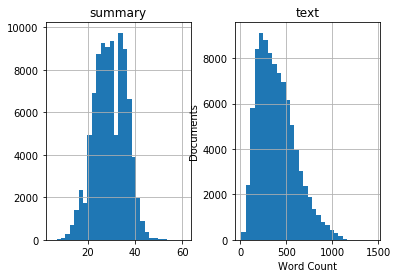

In [205]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

Max Text Lengths

In [206]:
MAX_TEXT_LEN = max([len(txt.split(' ')) for txt in df['text']])
MAX_SUMMARY_LEN = max([len(txt.split(' ')) for txt in df['summary']])
print(MAX_TEXT_LEN)
print(MAX_SUMMARY_LEN)

1453
61


### Finding Uncommon Words and Removing Them.

Uncommon words are classified as those that occur in the whole corpus less times than UNCOMMON_WORD_THRESHOLD







#### Text

In [0]:
# stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if not word.lower() in stop_words]))
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if not word.lower() in stop_words]))	


In [208]:
x_word_dict = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in x_word_dict.keys():
      x_word_dict[word] = 1
    else:
      x_word_dict[word] += 1

print(len(x_word_dict))
# sort so that extracting acceptable words is more efficient for larger vocab sizes
sorted_dict = sorted(x_word_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
x, y = zip(*sorted_dict)

380279


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [209]:
# find words that occur more than UNCOMMON_WORD_THRESHOLD times
accept_words = []
for word, occ in sorted_dict:
  if int(occ) > UNCOMMON_WORD_THRESHOLD:
    accept_words.append(word)
  else:
    break

# remove uncommon words    
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['text'][2])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['text'][2])


['say', 'year', 'people', 'one', 'make', 'go', 'would', 'take', 'time', 'also', 'get', 'report', 'told', 'two', 'like', 'come', 'us', 'first', 'work', 'day', 'know', 'country', 'could', 'cnn', 'use', 'government', 'last', 'call', 'see', 'new', 'want', 'include', 'official', 'well', 'show', 'state', 'world', 'accord', 'family', 'many', 'way', 'think', 'week', 'united', 'police', 'give', 'life', 'back', 'group', 'right', 'help', 'woman', 'home', 'need', 'even', 'new', 'child', 'kill', 'month', 'look', 'case', 'dont', 'million', 'three', 'obama', 'part', 'still', 'try', 'attack', 'us', 'much', 'place', 'states', 'issue', 'thing', 'statement', 'may', 'force', 'since', 'found', 'start', 'become', 'end', 'law', 'change', 'lead', 'around', 'president', 'city', 'military', 'death', 'team', 'president', 'believe', 'member', 'american', 'company', 'ask', 'good', 'support', 'release', 'point', 'public', 'begin', 'another', 'add', 'charge', 'really', 'move', 'high', 'school', 'man', 'im', 'put', '

In [210]:
x_word_dict_after = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in x_word_dict_after.keys():
      x_word_dict_after[word] = 1
    else:
      x_word_dict_after[word] += 1

print(len(x_word_dict_after))

77135


#### Summaries

In [211]:
y_word_dict = {}
summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in summary.iteritems():
  for word in row:
    if word not in y_word_dict.keys():
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))
sorted_dict = sorted(y_word_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
x, y = zip(*sorted_dict)

106595
[('says', 48618), ('NEW', 13094), ('say', 11859), ('US', 11463), ('people', 8463), ('one', 6300), ('new', 6257), ('first', 6226), ('Obama', 5874), ('years', 5833), ('two', 5739), ('said', 5715), ('police', 5359), ('also', 5040), ('New', 4866), ('killed', 4835), ('could', 4642), ('last', 4556), ('year', 4314), ('million', 4051), ('President', 3961), ('found', 3829), ('government', 3765), ('would', 3747), ('time', 3738), ('official', 3562), ('CNN', 3475), ('since', 3459), ('death', 3357), ('help', 3323), ('show', 3265), ('world', 3239), ('three', 3208), ('officials', 3180), ('home', 3059), ('group', 2998), ('may', 2933), ('World', 2931), ('Police', 2882), ('died', 2874), ('week', 2760), ('president', 2742), ('made', 2698), ('family', 2693), ('still', 2692), ('military', 2685), ('South', 2615), ('man', 2606), ('state', 2579), ('win', 2568), ('get', 2538), ('women', 2524), ('United', 2524), ('make', 2501), ('calls', 2495), ('take', 2464), ('10', 2448), ('back', 2430), ('like', 2413)

In [212]:
accept_words = []
for word, occ in sorted_dict:
  if int(occ) > UNCOMMON_WORD_THRESHOLD:
    accept_words.append(word)
  else:
    break
     
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['summary'][2])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['summary'][2])

['says', 'new', 'say', 'us', 'people', 'one', 'new', 'first', 'obama', 'years', 'two', 'said', 'police', 'also', 'new', 'killed', 'could', 'last', 'year', 'million', 'president', 'found', 'government', 'would', 'time', 'official', 'cnn', 'since', 'death', 'help', 'show', 'world', 'three', 'officials', 'home', 'group', 'may', 'world', 'police', 'died', 'week', 'president', 'made', 'family', 'still', 'military', 'south', 'man', 'state', 'win', 'get', 'women', 'united', 'make', 'calls', 'take', '10', 'back', 'like', 'children', 'second', 'attack', 'many', 'report', 'china', 'former', 'house', 'life', 'must', 'american', 'four', 'set', 'one', 'case', 'court', 'used', 'least', 'top', 'work', 'part', 'accused', 'law', 'north', 'team', 'day', 'arrested', 'use', 'charges', 'cup', 'media', 'shows', 'days', 'place', 'next', 'security', 'sunday', 'dead', 'monday', 'go', 'york', 'public', '20', 'health', 'john', 'leader', '1', 'country', 'among', 'way', 'two', 'charged', 'students', 'shot', 'repor

In [213]:
y_word_dict_after = {}
summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in summary.iteritems():
  for word in row:
    if word not in y_word_dict_after.keys():
      y_word_dict_after[word] = 1
    else:
      y_word_dict_after[word] += 1
print(len(y_word_dict_after))

22822


 Max lengths after removal of words

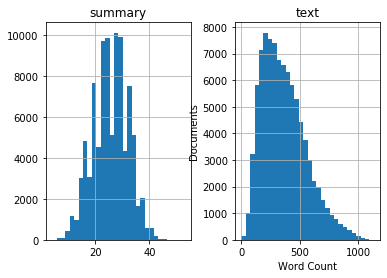

In [214]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')

# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

### Update Max Text Lenths After Uncommon Word Removal & Drop Empty Rows

In [215]:
print(df['text'][0])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_TEXT_LEN]))
print(df['text'][0])

LONDON England Reuters Harry Potter star Daniel Radcliffe gain access report 20 million 411 million fortune turn 18 Monday insists money wont cast spell Daniel Radcliffe Harry Potter Harry Potter Order Phoenix disappointment gossip columnist around world young actor say plan fritter cash away fast car drink celebrity party dont plan one people soon turn 18 suddenly buy massive sport car collection something similar told Australian interviewer earlier month dont think Ill particularly extravagant thing like buying thing cost 10 pound book CDs DVDs 18 Radcliffe able gamble casino buy drink pub see horror film Hostel Part II currently six place number one movie UK box office chart Details hell mark landmark birthday wrap agent publicist comment plan Ill definitely sort party say interview Hopefully none reading earnings first five Potter film held trust fund able touch Despite grow fame rich actor say keep foot firmly ground People always look say kid star go rail told reporter last month

In [216]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_SUMMARY_LEN]))
print(df['summary'][0])

Harry Potter star Daniel Radcliffe gets fortune turns 18 Monday Young actor says plans cash away earnings first five Potter films held trust fund
Harry Potter star Daniel Radcliffe gets fortune turns 18 Monday Young actor says plans cash away earnings first five Potter films held trust fund


In [217]:
# update max text lengths
MAX_TEXT_LEN = max([len(txt.split(' ')) for txt in df['text']])
MAX_SUMMARY_LEN = max([len(txt.split(' ')) for txt in df['summary']])
print(MAX_TEXT_LEN)
print(MAX_SUMMARY_LEN)

1130
53


In [218]:
# drop any lines that have no text or summary after the word removal process
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

False
(92465, 4)
(0, 4)
(92465, 4)
False


In [219]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
print(df['summary'].head())

0    sostok Harry Potter star Daniel Radcliffe gets...
1    sostok Mentally ill inmates Miami housed forgo...
2    sostok NEW thought going die driver says Man s...
3    sostok Five small found procedure none spokesm...
4    sostok NEW NFL chief Atlanta Falcons owner cri...
Name: summary, dtype: object


### Training-Validation Split

X - Articles text </br>
Y - Summaries

In [0]:
# convert to numpy array
X = np.array(df['text'])
Y = np.array(df['summary'])

In [221]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=TEST_TRAIN_SPLIT,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(78595,)
(13870,)
(78595,)
(13870,)


### Word Embeddings - Tokenization

X Tokenizer

In [222]:
word_dict = {}
text = df['text']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))

77135


In [223]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
x_tokenizer.fit_on_texts(list(X))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=MAX_TEXT_LEN, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=MAX_TEXT_LEN, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

77136


In [0]:
# with open('xtokenizer.pickle', 'wb') as handle:
#   pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Y Tokenizer

In [225]:
y_word_dict = {}
summ = df['summary']

for row in summ: 
  for word in row.split(" "):
    if word not in y_word_dict:
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))

22824


In [226]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=MAX_SUMMARY_LEN, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=MAX_SUMMARY_LEN, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words + 1
print(y_voc)
print(y_tokenizer.word_counts['sostok'],len(y_tr))

22825
92465 78595


In [0]:
# with open('ytokenizer.pickle', 'wb') as handle:
#   pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Learning Model

#### Encoder Model

In [0]:
#encoder input
encoder_inputs = Input(shape=(MAX_TEXT_LEN,))
#embedding layer
enc_emb =  Embedding(x_voc,EMBEDDING_DIM,trainable=True)(encoder_inputs)
# bidirectional encoder lstm 
encoder_lstm = Bidirectional(LSTM(LATENT_DIM,return_sequences=True,return_state=True))
# outputs and encoder final states
encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = encoder_lstm(enc_emb)

state_h = Concatenate()([fw_state_h, bw_state_h])
state_c = Concatenate()([fw_state_c, bw_state_c])
encoder_states = [state_h, state_c]

#### Decoder Model

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, EMBEDDING_DIM,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(LATENT_DIM*2, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)
                                                          
#dense layer 
#soft max creates a prob vector that allows us to determine the final output
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


#### Combined LSTM Model

In [230]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1130)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1130, 128)    9873408     input_17[0][0]                   
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 1130, 512),  788480      embedding_5[0][0]                
____________________________________________________________________________________________

In [0]:
optimizer = RMSprop(lr=LEARNING_RATE, rho=0.9)

In [0]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

- Early Stopping Callback to ensure we stop when Validation Loss is lowest - minimises risk of overfitting
- Model Checkpoint saves the model after each epoch so that we can load the model with the best weights later on. Alternatively, it allows us to continue training the model at a later data



In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2, restore_best_weights=False)
filepath = "./model/saved-model-{epoch:02d}.hdf5"
if COLAB:
  filepath = PATH + "project-model/saved-model-{epoch:02d}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#### Use this  to train a new model. To continue training a previously trained model see below

In [0]:
# reshape y from two dimensions to three dimensions
y_tr_3d = y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]
y_val_3d = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]

In [235]:
print(x_tr.shape)
print(y_tr.shape)
print(y_tr_3d.shape)
print(x_val.shape)
print(y_val.shape)
print(y_val_3d.shape)

(78595, 1130)
(78595, 53)
(78595, 52, 1)
(13870, 1130)
(13870, 53)
(13870, 52, 1)


In [236]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr_3d, batch_size=128, epochs=EPOCHS, callbacks=[es,mc], 
                    validation_data=([x_val,y_val[:,:-1]], y_val_3d))

Train on 78595 samples, validate on 13870 samples
Epoch 1/100
78595/78595 [==============================] - 2091s 27ms/step - loss: 3.9944 - val_loss: 3.6442
Epoch 2/100
78595/78595 [==============================] - 2100s 27ms/step - loss: 3.4427 - val_loss: 3.4141
Epoch 3/100
78595/78595 [==============================] - 2086s 27ms/step - loss: 3.2272 - val_loss: 3.3342
Epoch 4/100
78595/78595 [==============================] - 2080s 26ms/step - loss: 3.0884 - val_loss: 3.3031
Epoch 5/100
78595/78595 [==============================] - 2067s 26ms/step - loss: 2.9894 - val_loss: 3.2802
Epoch 6/100
78595/78595 [==============================] - 2072s 26ms/step - loss: 2.9117 - val_loss: 3.3000
Epoch 7/100
78595/78595 [==============================] - 2124s 27ms/step - loss: 2.8430 - val_loss: 3.3061
Epoch 00007: early stopping


#### This method is to only be used when loading a previously partially trained model

In [0]:
# model = load_model("./drive/My Drive/project-model/saved-model-53.hdf5")
# history = model.fit([x_tr,y_tr[:,:-1]], y_tr, callbacks=[mc], batch_size=BATCH_SIZE, epochs=1, validation_data=([x_val,y_val[:,:-1]], y_val))

### Plot training and validation loss overtime

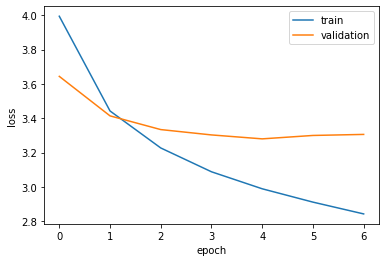

In [238]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plt.savefig('loss' + str(build_number) + '.png')
plt.show()

## Inference Model

In [0]:
# load model from drive
# model = load_model("./drive/My Drive/saved-model-53.hdf5")

In [240]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
print(reverse_source_word_index)
print(reverse_target_word_index)

{1: 'say', 2: 'one', 3: 'year', 4: 'people', 5: 'make', 6: 'us', 7: 'go', 8: 'would', 9: 'take', 10: 'new', 11: 'time', 12: 'also', 13: 'get', 14: 'two', 15: 'report', 16: 'like', 17: 'told', 18: 'come', 19: 'day', 20: 'first', 21: 'world', 22: 'last', 23: 'work', 24: 'state', 25: 'country', 26: 'know', 27: 'could', 28: 'president', 29: 'government', 30: 'see', 31: 'use', 32: 'cnn', 33: 'police', 34: 'call', 35: 'many', 36: 'want', 37: 'well', 38: 'show', 39: 'include', 40: 'official', 41: 'family', 42: 'even', 43: 'accord', 44: 'group', 45: 'way', 46: 'think', 47: 'week', 48: 'united', 49: 'life', 50: 'back', 51: 'right', 52: 'give', 53: 'help', 54: 'home', 55: 'woman', 56: 'city', 57: 'need', 58: 'may', 59: 'dont', 60: 'child', 61: 'three', 62: 'look', 63: 'kill', 64: 'still', 65: 'since', 66: 'month', 67: 'case', 68: 'million', 69: 'obama', 70: 'part', 71: 'try', 72: 'force', 73: 'house', 74: 'much', 75: 'attack', 76: 'court', 77: 'place', 78: 'states', 79: 'issue', 80: 'thing', 81:

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [242]:
encoder_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1130)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1130, 128)    9873408     input_17[0][0]                   
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 1130, 512),  788480      embedding_5[0][0]                
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 512)          0           bidirectional_3[0][1]            
                                                                 bidirectional_3[0][3]     

In [0]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(LATENT_DIM*2,))
decoder_state_input_c = Input(shape=(LATENT_DIM*2,))
decoder_hidden_state_input = Input(shape=(MAX_TEXT_LEN,LATENT_DIM*2))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)
decoder_states = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + decoder_states)
# decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)

In [246]:
decoder_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 128)    2921600     input_18[0][0]                   
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 512)          0                                            
___________________________________________________________________________________________

### Methods for Reversing Word Embeddings

In [0]:
# def seq2summary(input_seq):
#     newString=''
#     for i in input_seq:
#         if(i!=0):
#             newString=newString+reverse_target_word_index[i]+' '
#     return newString

# def seq2text(input_seq):
#     newString=''
#     for i in input_seq:
#         if(i!=0):
#             newString=newString+reverse_source_word_index[i]+' '
#     return newString

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Summarisation Method 

In [0]:
target_word_index=y_tokenizer.word_index
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
# # Standard Decode Sequence Method - selects most probable word using argmax
# def decode_sequence(input_seq): 
#     # Encode the input as state vectors.
#     e_out, e_h, e_c = encoder_model.predict(input_seq)
#     target_seq = np.zeros((1, y_voc))
#     stop_condition = False
#     decoded_sentence = ''

#     while not stop_condition:
#       # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
#       output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
#       sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])
#       # print(output_tokens[0, -1, :].shape) (y_voc, None)
#       if (sampled_token_index != 0 ):
#         sampled_token = reverse_target_word_index[sampled_token_index]
#         decoded_sentence += ' '+sampled_token
#       else :
#         print("sadface")
#         stop_condition = True
#       # if (len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
#       if (len(decoded_sentence.split()) >= (9)):
#               stop_condition = True

#       # Update the target sequence for next input
#       target_seq = np.zeros((1, y_voc))
#       target_seq[0, sampled_token_index] = 1

#       # Update internal states
#       e_h, e_c = h, c
      
#     return decoded_sentence

In [0]:
# Decode Sequence - don't allow next token to be the same as the previous token
def decode_sequence2(input_seq): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, y_voc))
    # target_seq[0, i] = 1
    # print(target_seq.shape)
    stop_condition = False
    decoded_sentence = ""
    # decoded_sentence = reverse_target_word_index[i]
    last_token = [i]
    while not stop_condition:
      # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 

      # print("ot")
      # print(output_tokens)
      # print("ot[0-1]")
      # print(output_tokens[0, -1, :])
      # print(np.argmax(output_tokens[0, -1, :]))
      # print("out[1:]")
      # print(output_tokens[0, -1, :][1:])
      # print(np.argmax(output_tokens[0, -1, :][1:]))

      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])
      # prevent it being the same as the last token
      if(sampled_token_index in last_token):
        a = np.delete(output_tokens[0, -1, :][1:], sampled_token_index)
        sampled_token_index=np.argmax(a)
        if sampled_token_index >= last_token[-1] :
          sampled_token_index = sampled_token_index+1 
      # print(sampled_token_index)
      # print(sampled_token_index)
      last_token.append(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print(sampled_token)
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      target_seq = np.zeros((1, y_voc))
      target_seq[0, sampled_token_index] = 1
      # print(target_seq)
      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

In [0]:
# Decode Sequence - don't allow next token to be the same as the previous token + feed in first token of orignal summary
def decode_sequence3(input_seq, int): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, y_voc))
    target_seq[0, i] = 1
    stop_condition = False
    decoded_sentence = reverse_target_word_index[i]
    last_token = [i]
    while not stop_condition:
      # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 

      # print("ot")
      # print(output_tokens)
      # print("ot[0-1]")
      # print(output_tokens[0, -1, :])
      # print(np.argmax(output_tokens[0, -1, :]))
      # print("out[1:]")
      # print(output_tokens[0, -1, :][1:])
      # print(np.argmax(output_tokens[0, -1, :][1:]))

      # remove first element to always prevent it being zero? could just add one to the count...either way it won't make much difference
      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])

      # prevent it being the same as the last token
      if(sampled_token_index in last_token):
        a = np.delete(output_tokens[0, -1, :][1:], sampled_token_index)
        sampled_token_index=np.argmax(a)
        if sampled_token_index >= last_token[-1] :
          sampled_token_index = sampled_token_index+1 
      # print(sampled_token_index)

      last_token.append(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
              stop_condition = True

      # Update the target sequence.
      target_seq = np.zeros((1, y_voc))
      target_seq[0, sampled_token_index] = 1

      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

## Test Model Output

Note: *I think there isn't enough data being passed in and so the argmax value always is 0 - it can't learn what should be next*

In [0]:
def getRouge(gt, pred):
  return rouge.get_scores(pred, gt)

In [252]:
for i in range(0,10):
    print("----------------------")
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])

    if (original !=""):
      # feed the first word of the original summary into the encoder (used for decode_seq3)
      # a = nltk.word_tokenize(original)[0]
      # for val,word in reverse_target_word_index.items():
      #   if word == a:
      #     i = val
      print("Original summary:",original)
      # reshape data into correct format for encoder
      a = x_tr[i].reshape(1,MAX_TEXT_LEN)
      # summary2 = decode_sequence2(a)
      summary = decode_sequence(a)
      # summary3 = decode_sequence3(a, i)
      print("Generated summary:",summary)
      # print("Generated summary2:",summary2)
      # print("\n")
      # print("Generated summary3:",summary3)
      # print("\n")

      if summary != "":    
        print("ROUGE score: ")
        score = getRouge(str(summary), str(original))
        print(score)
        # print(score[0].get('rouge-1').get('f'))
        # print(score[0].get('rouge-1').get('p'))
        # print(score[0].get('rouge-1').get('r'))
      # if summary != "":    
      #   print("ROUGE score: ")
      #   score = getRouge(str(summary2), str(original))
      #   print(score)
      #   print(score[0].get('rouge-1').get('f'))
      #   print(score[0].get('rouge-1').get('p'))
      #   print(score[0].get('rouge-1').get('r'))
      # if summary3 != "":    
      #   print("ROUGE score: ")
      #   score = getRouge(str(summary3), str(original))
      #   print(score)
      #   print(score[0].get('rouge-1').get('f'))
      #   print(score[0].get('rouge-1').get('p'))
      #   print(score[0].get('rouge-1').get('r'))

----------------------
Article: hundreds russians hit street moscow sunday rally promote peace equality response rash ethnic violence unrest staterun medium report moscow everyone demonstration square drew 1500 participant accord ria novosti people come intend put event occur moscow december 11 15 say viktor one event organizer believe riot moscow cause pu burst police officer set metal detector around square check knife weapon bid avoid repeat street violence earlier month turmoil begin southern moscow death 28 kyrgyzstan migrant authority say kill brawl migrant russias north caucasus region december 6 five day later 5000 nationalist football hooligan clashed moscow police unsanctioned mass memorial fellow supporter turn violent accord state medium confrontation take place square outside kremlin lead arrest 65 spartak moscow fan disobedience moscow police spokesman viktor say accord official russian news agency itartass head spartak moscow fan club told ria novosti showdown nothing sp

In [253]:
for i in range(1243,1253):
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])

    if (original !=""):
      # a = nltk.word_tokenize(original)[0]
      # for val,word in reverse_target_word_index.items():
      #   if word == a:
      #     i = val
      print("Original summary:",original)
      a = x_tr[i].reshape(1,MAX_TEXT_LEN)
      summary = decode_sequence(a)
      print("Generated summary:",summary)
      print("\n")

      if summary != "":    
        print("ROUGE score: ")
        score = getRouge(str(summary), str(original))
        print(score)
        print(score[0].get('rouge-1').get('f'))
        print(score[0].get('rouge-1').get('p'))
        print(score[0].get('rouge-1').get('r'))

Article: news make headline personal story make last impact people touch life million year cnn invite people share personal essay world deliver dozens ireporters courage pour heart unforgettable story pain loss joy courage anger many publish cnncom parenting huge topic year gun control frustration government also people mind 2013 come close look back best story receive people share mother raise kid without religion deborah mitchell stir intense debate cnncom early january post seven reason raise child without god readers disagreed view flag ireport inappropriate many time put note ask people stop mitchell mother two teenager texas say simply want people stop fear atheist want religion go away write want child free believe story drew comment ireport story date result book contract mitchell memoir growing parents guide raising kids without religion come spring woman whose son taught oscar pistorius man cynthia always search role model 10yearold son whose right hand amputate birth first t

In [0]:
# print(y_sorted_dict)
# print(type(y_sorted_dict))
# for x,y in y_sorted_dict:
#   if x.lower() == "april":
#     print(y)

## Evaluation

Using ROUGE (Recall-Orientated Understanding Gisting Evaluation) to evaluate the generated summaries.

*Note: This takes a long time, especially with large datasets* 

In [0]:
# def get_overlapping_words(x, y):
#   num=0
#   x = nltk.word_tokenize(x)
#   y = nltk.word_tokenize(y)
#   for word in y:
#     if word in x:
#       num = num+1
#       x.remove(word)
#     else:
#       return num

# def precision(target, generated):
#   length = len(target)
#   for i in range (0, length):
#     num_overlapping_words = get_overlapping_words(target[i], generated[i])
#     generated_summary_len = len(generated[i])
#     if generated_summary_len == 0 :
#         return 0.0
#     else : 
#       return num_overlapping_words / generated_summary_len

### For Training Data

In [254]:
print(len(x_tr))

78595


In [0]:
tr_target_summary = []
tr_generated_summary = []
x_tr_len = len(x_tr)

f_ov = 0
p_ov = 0
r_ov = 0
# x_val_len = 1
for i in range(0,x_tr_len):
  print(i)
  original = seq2summary(y_tr[i])
  if original != "" :
    tr_target_summary.append(original)
    print(original)
    x_i = x_tr[i].reshape(1,MAX_TEXT_LEN)
    summary = decode_sequence(x_i)
    print(summary)
    print("-----")
    tr_generated_summary.append(summary)
    score = getRouge(str(summary), str(original))
    f_ov += float(score[0].get('rouge-1').get('f'))
    p_ov += float(score[0].get('rouge-1').get('p'))
    r_ov += float(score[0].get('rouge-1').get('r'))

In [0]:
# print("precision : " + str(precision(tr_target_summary, tr_generated_summary)))
print("Avg F Score: " + str(f_ov/x_tr_len))
print("Avg Precision: " + str(p_ov/x_tr_len))
print("Avg Recall: " + str(r_ov/x_tr_len))

### For Validation Data

In [255]:
print(len(x_val))

13870


In [0]:
val_target_summary = []
val_generated_summary = []
x_val_len = len(x_val)
f_ov = 0
p_ov = 0
r_ov = 0

for i in range(0,x_val_len):
  print(i)
  original = seq2summary(y_val[i])
  print(original)
  val_target_summary.append(original)
  x_i = x_val[i].reshape(1,MAX_TEXT_LEN)
  summary = decode_sequence(x_i)
  print(summary)
  val_generated_summary.append(summary)
  score = getRouge(str(summary), str(original))
  print(score)
  print("-----")
  f_ov += float(score[0].get('rouge-1').get('f'))
  p_ov += float(score[0].get('rouge-1').get('p'))
  r_ov += float(score[0].get('rouge-1').get('r'))

Streaming output truncated to the last 5000 lines.
[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]
-----
4075
texas police confiscated money 2007 traffic stop daniels stopped driving 37 mph zone others property taken filed lawsuit towns officials say done nothing wrong 
 police say man arrested colorado california arizona police say officers arrested california california arizona police say officers involved criminal charges allege
[{'rouge-1': {'f': 0.11111110666666683, 'p': 0.08333333333333333, 'r': 0.16666666666666666}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.092592592592, 'p': 0.08333333333333333, 'r': 0.16666666666666666}}]
-----
4076
roland martin michael jordan aware image kept covered even locker room says jordan could advise kate middleton world cover says royals want pictures sell people want shocked martin world privacy gone coming back youre naked 
 queens club 24yearol

In [2]:
# print("precision : " + str(precision(val_target_summary, val_generated_summary)))
print("Avg F Score: " + str(f_ov/x_val_len))
print("Avg Precision: " + str(p_ov/x_val_len))
print("Avg Recall: " + str(r_ov/x_val_len))

NameError: ignored

# Inputting New Data

In [0]:
def getpos(word):
  pos = nltk.pos_tag([word])[0][1][0]
  wordnet_conv = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
  if pos in wordnet_conv.keys():
    return wordnet_conv.get(pos)
  return ""

In [0]:
def lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  text_tokenized = inp_df['text'].apply(lambda x: nltk.word_tokenize(x))
  print("lemmatize with pos")
  for i in range(0,len(text_tokenized)):
    text_lemmatized = []
    for word in text_tokenized[i]:
      pos = getpos(word)
      if pos != "":
        lemma = lemmatizer.lemmatize(word, pos)
        text_lemmatized.append(lemma)
      else :
        text_lemmatized.append(word)
    text_lemmatized = ' '.join(map(str, text_lemmatized))
    inp_df['text'][i] = text_lemmatized


In [0]:
# input1 = "(CNN) — Earlier this year, Delta Air Lines announced a rethink on reclining seats. In an effort to disrupt fewer passengers' travel experiences, Delta said it'd begin revamping some of its jets to reduce the recline of coach seats from four inches to two inches and the recline of first class seats from 5.5 inches to 3.5 inches. For those who abhor the recline option, it's a small step. And for those who value it, well, it's a compromise. This seemingly innocuous topic is one where there are very much two minds on what's acceptable and what's not. Two CNN Travel staffers engage in a friendly debate about seat recline. Your seat. Your decision. Stacey Lastoe, senior editor at CNN Travel, is of above-average height and makes no apology about reclining; it's her right as a plane, train and bus passenger. She encourages the person sitting in front of her to recline as well. On the first leg of my flight to Japan for my honeymoon, my husband and I got upgraded to first class. Although it would just be a few hours in the sky en route to Dallas, I was excited about sipping Champagne, sitting back and relaxing. Flute in hand, I pushed back to recline my seat for maximum relaxation. But it would not budge; I appeared to be stuck in a dysfunctional seat. Or was I? Turns out the gentleman behind me had a dog in a crate down between his legs, positioned so the seat in front of his -- my seat -- had nowhere to go. Because we were newlyweds and loving every moment of it, I did not mind when my husband turned to the man and told him his wife wanted to recline her seat and asked if he could please rearrange his dog crate to allow for everyones comfort."
input1 = "Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign Relations Committee hold hearing matter Tuesday Sen Robert Menendez say Transcript Read Obamas full remark Syrian crisis Latest development UN inspector leave Syria Obamas remark come shortly UN inspector left Syria carry evidence determine whether chemical weapon use attack early last week Damascus suburb The aim game mandate clear ascertain whether chemical weapon use UN spokesman Martin Nesirky told reporter Saturday But use weapon report toxic gas attack Damascus suburb August 21 key point global debate Syrian crisis Top US official say there doubt Syrian government behind Syrian official deny responsibility blame jihadist fight rebel British US intelligence report say attack involve chemical weapon UN official stress importance wait official report inspector The inspector share finding UN SecretaryGeneral Ban Kimoon Ban say want wait UN team final report complete present UN Security Council The Organization Prohibition Chemical Weapons nine inspector belong say Saturday could take three week analyze evidence collect It need time able analyze information sample Nesirky say He note Ban repeatedly say alternative political solution crisis Syria military solution option Bergen Syria problem hell US Obama This menace must confront Obamas senior adviser debate next step take president comment Saturday come amid mount political pressure situation Syria Some US lawmaker call immediate action others warn step could become quagmire Some global leader express support British Parliaments vote military action earlier week blow Obamas hope get strong backing key NATO ally On Saturday Obama propose say would limited military action Syrian President Bashar alAssad Any military attack would openended include US ground force say Syrias allege use chemical weapon earlier month assault human dignity president say A failure respond force Obama argue could lead escalate use chemical weapon proliferation terrorist group would people harm In world many danger menace must confront Syria missile strike What would happen next Map US allied asset around Syria Obama decision come Friday night On Friday night president make lastminute decision consult lawmaker What happen vote Its unclear A senior administration official told CNN Obama authority act without Congress even Congress reject request authorization use force Obama Saturday continued shore support strike alAssad government He spoke phone French President Francois Hollande Rose Garden speech The two leader agree international community must deliver resolute message Assad regime others would consider use chemical weapon crime unacceptable violate international norm held accountable world White House say Meanwhile uncertainty loom Congress would weigh US military official say remain ready 5 key assertion US intelligence report Syria Syria Who want chemical weapon horror Reactions mixed Obamas speech A spokesman Syrian National Coalition say opposition group disappointed Obamas announcement Our fear lack action could embolden regime repeat attack serious way say spokesman Louay Safi So quite concerned Some member Congress applaud Obamas decision House Speaker John Boehner Majority Leader Eric Cantor Majority Whip Kevin McCarthy Conference Chair Cathy McMorris Rodgers issue statement Saturday praise president Under Constitution responsibility declare war lie Congress Republican lawmaker say We glad president seek authorization military action Syria response serious substantive question raise More 160 legislator include 63 Obamas fellow Democrats sign letter call either vote least full debate US action British Prime Minister David Cameron whose attempt get lawmaker country support military action Syria fail earlier week respond Obamas speech Twitter post Saturday I understand support Barack Obamas position Syria Cameron say An influential lawmaker Russia stood Syria criticize United States theory The main reason Obama turn Congress military operation get enough support either world among ally US United States Alexei Pushkov chairman internationalaffairs committee Russian State Duma say Twitter post In United States scatter group antiwar protester around country take street Saturday Like many Americanswere tire United States get involve invade bombing country say Robin Rosecrans among hundred Los Angeles demonstration What Syrias neighbor think Why Russia China Iran stand Assad Syrias government unfazed After Obamas speech military political analyst Syrian state TV say Obama embarrass Russia opposes military action Syria cry help someone come rescue face two defeat political military level Syrias prime minister appear unfazed saberrattling The Syrian Armys status maximum readiness finger trigger confront challenge Wael Nader alHalqi say meeting delegation Syrian expatriate Italy accord banner Syria State TV broadcast prior Obamas address An anchor Syrian state television say Obama appear prepare aggression Syria base repeat lie A top Syrian diplomat told state television network Obama face pressure take military action Israel Turkey Arabs rightwing extremist United States I think do well Cameron term take issue Parliament say Bashar Jaafari Syrias ambassador United Nations Both Obama Cameron say climbed top tree dont know get The Syrian government deny use chemical weapon August 21 attack say jihadist fight rebel use effort turn global sentiment British intelligence put number people kill attack 350 On Saturday Obama say told well 1000 people murder US Secretary State John Kerry Friday cite death toll 1429 400 child No explanation offer discrepancy Iran US military action Syria would spark disaster Opinion Why strike Syria bad idea"
inp_df = pd.DataFrame(columns=['text', 'summary'])
inp_df = inp_df.append({'text': str(input1), 'summary': ""}, ignore_index=True)
inp_df.head()

In [0]:
inp_df['text'] = inp_df['text'].apply(lambda x: re.sub(r'\(CNN\)|--|[^\w\s\.]','',x)).apply(lambda x: re.sub(r'(\.(?=[\s\r\n]|$))','',x)).apply(lambda x: re.sub(r'\n',' ',x)).apply(lambda x: re.sub(r'\.','',x))

In [0]:
# remove stop words
stop_words = set(stopwords.words('english'))
inp_df['text'] = inp_df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if not word in stop_words]))

In [0]:
#lemmatize
lemmatization(inp_df['text'])
print(inp_df['text'])

In [0]:
seq = np.array(inp_df['text'])
print(seq)

In [0]:
seq_tokenizer = x_tokenizer.texts_to_sequences(seq)
#padding zero upto maximum lAength
seq_tokenizer_padded = pad_sequences(seq_tokenizer,  maxlen=MAX_TEXT_LEN, padding='post')

gen_summary = decode_sequence(seq_tokenizer_padded)

original_txt = ' '.join(seq)

print("---")
print("Original: " + original_txt)
print("Generated Summary: " + gen_summary)
print("ROUGE score: ")
print(getRouge(summary, original_txt))